In [2]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, multilabel_confusion_matrix 
from ModelHandler import ModelHandler
import pickle

folderPath = "Weights/MultiLabel/2/"
folderDataPath = "Weights/MultiLabel/2/"
signalBaseLength = 12800
ngrids = 5

In [19]:
bestModel = ModelHandler.loadModel(folderPath + "best_model.h5", type_weights=None) # Load model
dict_data = pickle.load(open(folderDataPath + "sorted_aug_data_" + str(ngrids) + "_" + str(signalBaseLength) + ".p", "rb")) # Load data
x_train = dict_data["x_train"]
x_test = dict_data["x_test"]
y_train = dict_data["y_train"]
y_test = dict_data["y_test"]

In [20]:
# threshold = 0.5
final_prediction, final_groundTruth = [], []
for xi, yclass, ytype in zip(x_test, y_test["classification"], y_test["type"]):
    pred = bestModel.predict(np.expand_dims(xi, axis=0))
    prediction = np.max(pred[2][0],axis=0) #> threshold
    groundTruth = np.max(yclass,axis=0) #> threshold

    final_prediction.append(prediction)
    final_groundTruth.append(groundTruth)

final_groundTruth = np.array(final_groundTruth)
final_prediction = np.array(final_prediction)

**The result is a class-wise confusion matrix on the following format**:

$$
    cm = \left [ \begin{matrix} tn & fn \\ fp & tp \end{matrix} \right ]
$$

In [3]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

/home/lucasnolasco/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


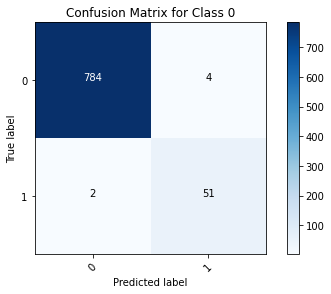

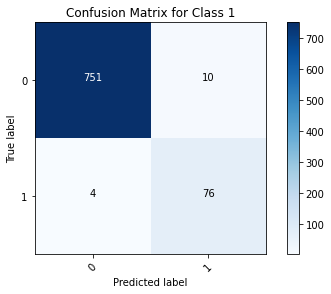

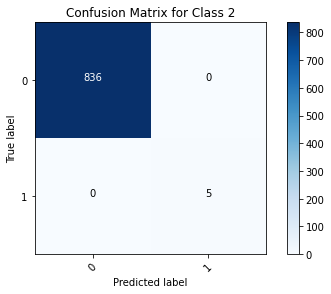

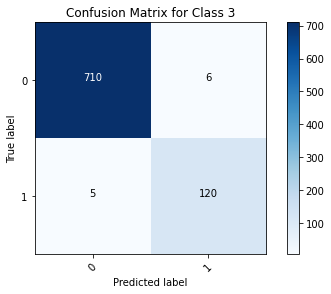

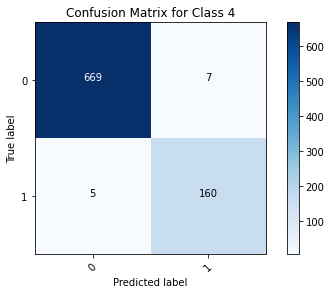

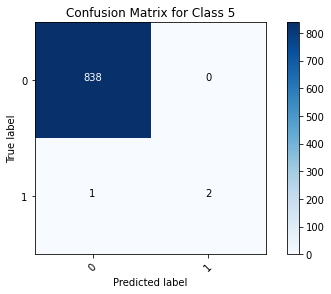

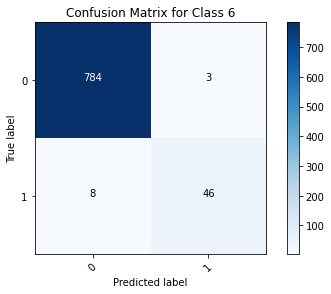

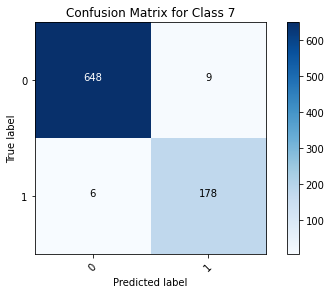

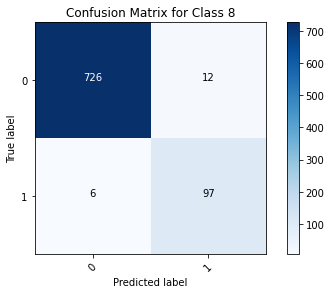

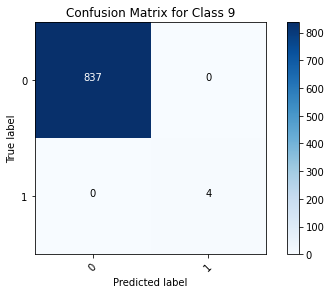

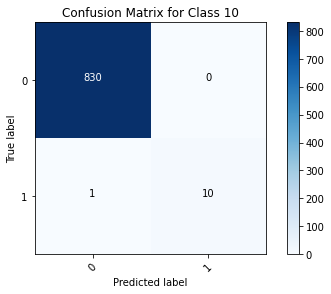

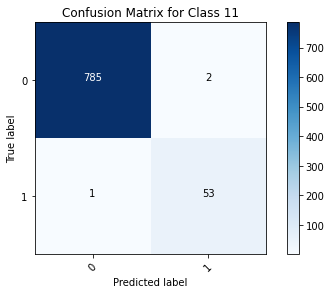

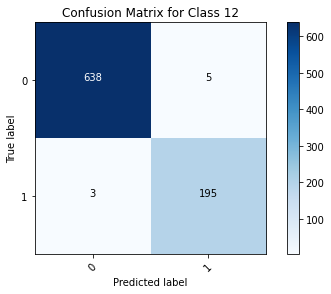

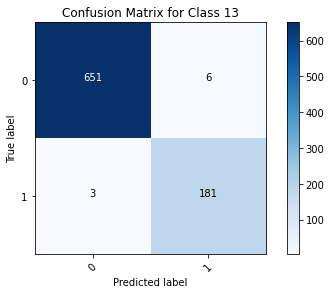

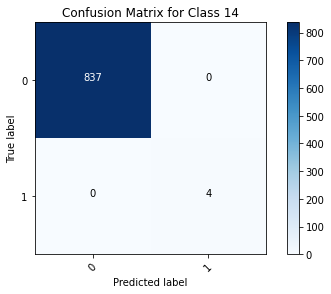

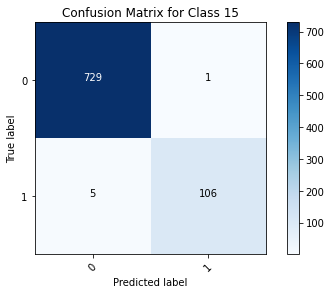

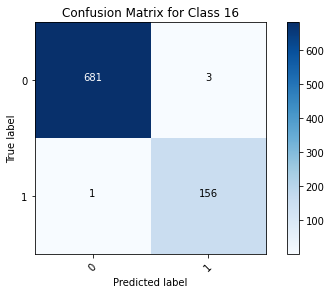

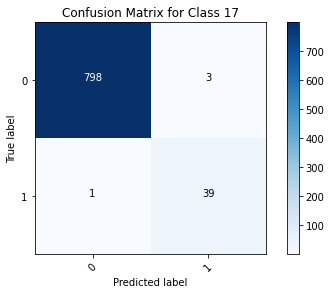

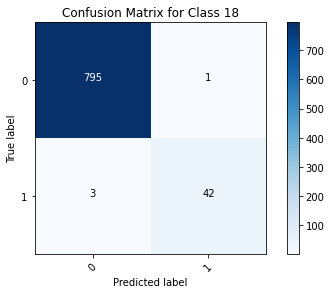

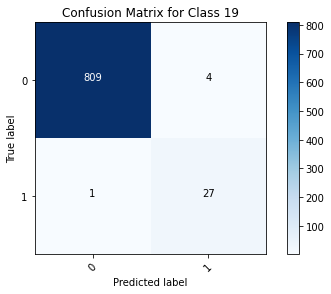

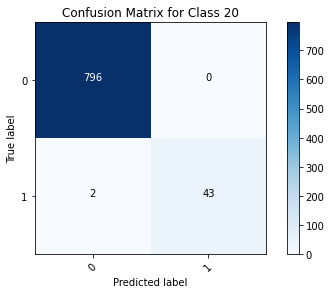

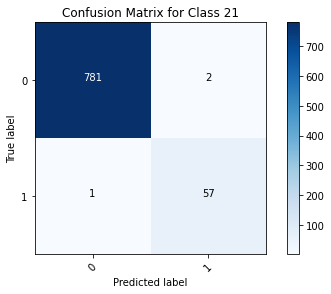

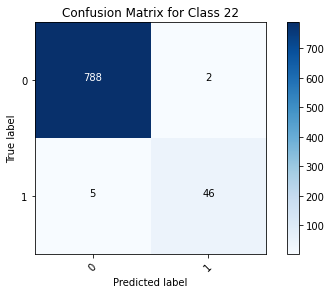

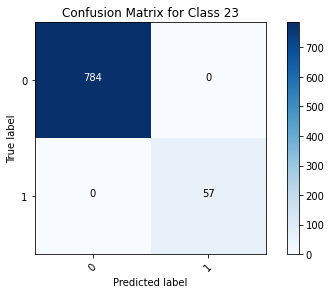

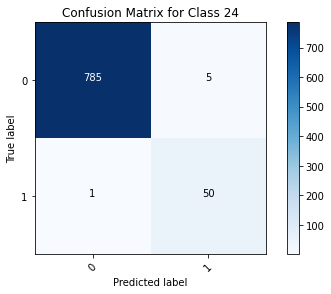

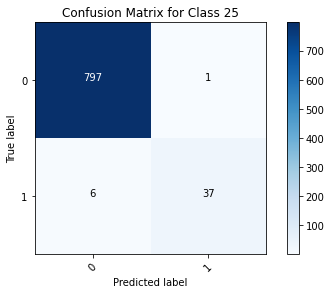

In [4]:
import matplotlib.pyplot as plt

threshold = 0.5
all_cm = multilabel_confusion_matrix(final_groundTruth > threshold, final_prediction > threshold, samplewise=False)

for i, cm in enumerate(all_cm):
    plt.figure()
    plot_confusion_matrix(cm, classes = range(2), title= f"Confusion Matrix for Class {i}", normalize=False)
    plt.savefig(f"/home/lucasnolasco/confusion_matrix/1_no_norm/{i}.png")

plt.show()

**ROC Curves**

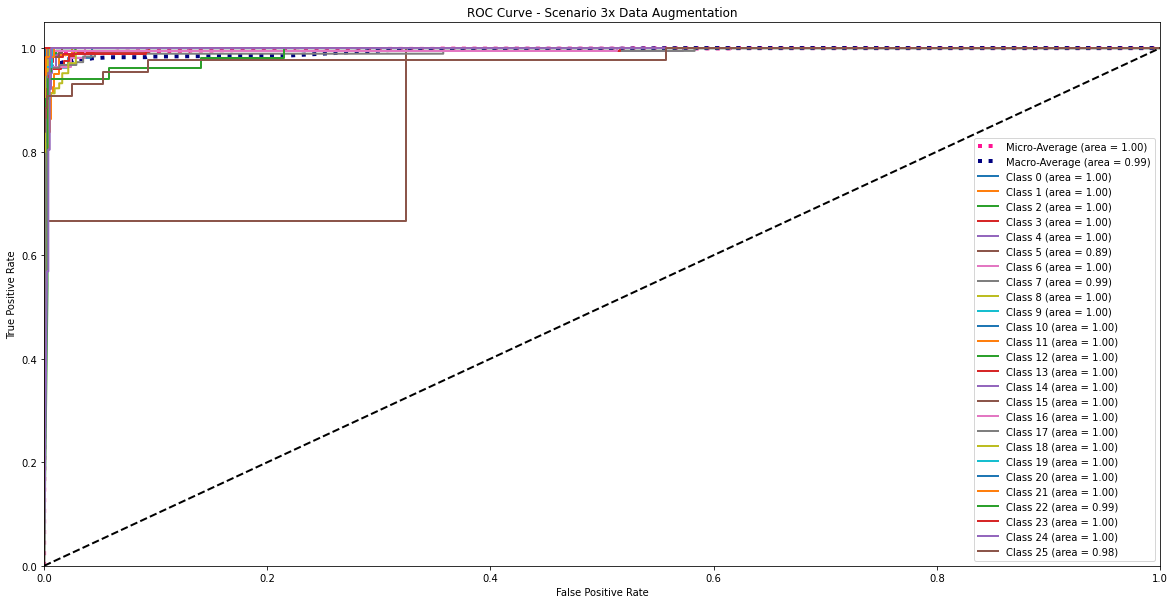

In [2]:
# Example extracted from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
import matplotlib.colors as mcolors

n_classes = 26
lw = 2 # line width (TODO: check if this is really line width)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(final_groundTruth[:, i], final_prediction[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(np.array(final_groundTruth).ravel(), np.array(final_prediction).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(20,10))
plt.plot(fpr["micro"], tpr["micro"], label = f'Micro-Average (area = {roc_auc["micro"]:0.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"], label = f'Macro-Average (area = {roc_auc["macro"]:0.2f})',
         color='navy', linestyle=':', linewidth=4)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=lw, label= f'Class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Scenario 3x Data Augmentation')
plt.legend(loc="lower right")
plt.show()

In [1]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, multilabel_confusion_matrix 
from ModelHandler import ModelHandler
import pickle

folderPath = "Weights/Final/cenario1/"
folderDataPath = "Weights/Final/cenario1/"
signalBaseLength = 12800
ngrids = 5

fold = 8

dict_data = pickle.load(open(folderDataPath + "sorted_aug_data_" + str(ngrids) + "_" + str(signalBaseLength) + ".p", "rb")) # Load data
x_train = dict_data["x_train"]
x_test = dict_data["x_test"]
y_train = dict_data["y_train"]
y_test = dict_data["y_test"]

X_all = np.vstack((x_train, x_test))
ydet_all = np.vstack((y_train["detection"], y_test["detection"]))
ytype_all = np.vstack((y_train["type"], y_test["type"]))
yclass_all = np.vstack((y_train["classification"], y_test["classification"]))

final_acc_on, final_acc_off, final_acc = [], [], []

foldFolderPath = folderPath + str(fold) + "/"

train_index = np.load(foldFolderPath + "train_index.npy")
test_index = np.load(foldFolderPath + "test_index.npy")

bestModel = ModelHandler.loadModel(foldFolderPath + "best_model.h5", type_weights=None) # Load model

x_train = X_all[train_index]
x_test = X_all[test_index]
y_train["detection"] = ydet_all[train_index]
y_test["detection"] = ydet_all[test_index]
y_train["type"] = ytype_all[train_index]
y_test["type"] = ytype_all[test_index]
y_train["classification"] = yclass_all[train_index]
y_test["classification"] = yclass_all[test_index]

final_prediction, final_groundTruth = [], []
for xi, yclass, ytype in zip(x_test, y_test["classification"], y_test["type"]):
    pred = bestModel.predict(np.expand_dims(xi, axis=0))
    prediction = np.max(pred[2][0],axis=0) #> threshold
    groundTruth = np.max(yclass,axis=0) #> threshold

    final_prediction.append(prediction)
    final_groundTruth.append(groundTruth)

final_groundTruth = np.array(final_groundTruth)
final_prediction = np.array(final_prediction)

del x_train
del x_test
del y_train["detection"]
del y_train["classification"]
del y_train["type"]
del y_test["detection"]
del y_test["classification"]
del y_test["type"]

In [7]:
import matplotlib.colors as mcolors
for color in mcolors.get_named_colors_mapping():
    print(color)

xkcd:cloudy blue
xkcd:dark pastel green
xkcd:dust
xkcd:electric lime
xkcd:fresh green
xkcd:light eggplant
xkcd:nasty green
xkcd:really light blue
xkcd:tea
xkcd:warm purple
xkcd:yellowish tan
xkcd:cement
xkcd:dark grass green
xkcd:dusty teal
xkcd:grey teal
xkcd:macaroni and cheese
xkcd:pinkish tan
xkcd:spruce
xkcd:strong blue
xkcd:toxic green
xkcd:windows blue
xkcd:blue blue
xkcd:blue with a hint of purple
xkcd:booger
xkcd:bright sea green
xkcd:dark green blue
xkcd:deep turquoise
xkcd:green teal
xkcd:strong pink
xkcd:bland
xkcd:deep aqua
xkcd:lavender pink
xkcd:light moss green
xkcd:light seafoam green
xkcd:olive yellow
xkcd:pig pink
xkcd:deep lilac
xkcd:desert
xkcd:dusty lavender
xkcd:purpley grey
xkcd:purply
xkcd:candy pink
xkcd:light pastel green
xkcd:boring green
xkcd:kiwi green
xkcd:light grey green
xkcd:orange pink
xkcd:tea green
xkcd:very light brown
xkcd:egg shell
xkcd:eggplant purple
xkcd:powder pink
xkcd:reddish grey
xkcd:baby shit brown
xkcd:liliac
xkcd:stormy blue
xkcd:ugly 